In [7]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import os
fontsize = 16


sns.set_context("paper", rc={
    "font.size": fontsize,
    "axes.titlesize": fontsize,
    "axes.labelsize": fontsize,
    "xtick.labelsize": fontsize,
    'ytick.labelsize': fontsize,
    'grid.linewidth': 1.5,
})
sns.set_style("ticks", {"xtick.major.size": 14, "ytick.major.size": 14})

plt.rc('font', family='Times New Roman', weight='bold', size=fontsize)
# plt.rc('lines', lw=3.5)
plt.rcParams.update(
    {'font.size': fontsize, "axes.grid": True, 'grid.linestyle': '-.'})


path_mac = "/Users/jairwu/resources/FaaS/batching-request/test/asplos/dispatch_interval_sensitivity/results/io"
path_linux = "."
PATH = utils.get_data_path(path_mac=path_mac, path_linux=path_linux)
PLOT_DIR = '../plots'
os.system(f"mkdir -p {PLOT_DIR}")
FIGSIZE = (4.5, 2.5)
sns.color_palette("Blues")
pal = sns.color_palette("Blues")
display(pal)
mypal = pal.as_hex()[2:]
print(mypal)


[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

['#89bedc', '#539ecd', '#2b7bba', '#0b559f']


### 每一种策略的 执行时间 受 Dispatch_intervel 的影响

In [8]:

all_csvs = list(
    map(lambda x: f'{x.split(".csv")[0]}', glob.glob(f"{PATH}/latency*.csv")))
strategies = ['BaseBatching', "Kraken", "SFS",  "n_Batching"]
legends = ['Vanilla', "Kraken", "SFS",  "FaaSBatch"]
strategy_csvs = {
    strategy: list(filter(lambda x: strategy in x, all_csvs)) for strategy in strategies
}

data = pd.DataFrame()
for strategy, csvs in strategy_csvs.items():
    for csv in csvs:
        df = pd.read_csv(f"{csv}.csv")
        dispatch_interval = csv.split("_")[-1]
        df['dispatch_interval'] = dispatch_interval
        if strategy == 'n_Batching':
            df['strategy'] = "FaaSBatch"
        elif strategy == "BaseBatching":
            df['strategy'] = 'Vanilla'
        else:
            df['strategy'] = strategy
        data = pd.concat([df, data])

data['exec_time(s)'] = data['exec_time(ms)'] / 1000  # Converts ms to s
data.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill="")


#####执行时间评估######

Disaptch interval 为 0.01 时:
FaaSBatch 相对于 SFS 优化了：86.8616853979623%, FaaSBatch 相对于 Kraken 优化了：87.54806839693498%, FaaSBatch 相对于 Vanilla 优化了：84.8675519127303%, 

Disaptch interval 为 0.05 时:
FaaSBatch 相对于 SFS 优化了：89.54568392918064%, FaaSBatch 相对于 Kraken 优化了：93.42565963888498%, FaaSBatch 相对于 Vanilla 优化了：89.7690319075242%, 

Disaptch interval 为 0.1 时:
FaaSBatch 相对于 SFS 优化了：88.77885959005539%, FaaSBatch 相对于 Kraken 优化了：89.31268366858681%, FaaSBatch 相对于 Vanilla 优化了：88.05928803546266%, 

Disaptch interval 为 0.15 时:
FaaSBatch 相对于 SFS 优化了：74.98015895221573%, FaaSBatch 相对于 Kraken 优化了：73.57995326667047%, FaaSBatch 相对于 Vanilla 优化了：75.09291868056222%, 

Disaptch interval 为 0.2 时:
FaaSBatch 相对于 SFS 优化了：87.86659898377054%, FaaSBatch 相对于 Kraken 优化了：90.65437699067424%, FaaSBatch 相对于 Vanilla 优化了：87.91453139836581%, 

Disaptch interval 为 0.3 时:
FaaSBatch 相对于 SFS 优化了：85.0007676289081%, FaaSBatch 相对于 Kraken 优化了：85.11255930369892%, FaaSBatch 相对于 Vanilla 优化了：85.10755923154828%, 

Disaptch i

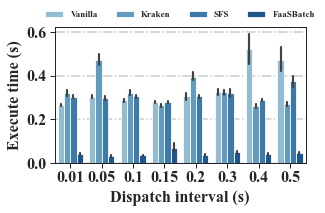

In [9]:

fig, ax1 = plt.subplots(figsize=FIGSIZE)
sns.barplot(x="dispatch_interval", y="exec_time(s)", hue="strategy", hue_order=legends,
            data=data, palette=mypal, order=sorted(data['dispatch_interval'].unique()))
sns.move_legend(ax1, "lower center", bbox_to_anchor=(.5, 1),
                ncol=4, title=None, frameon=False, fontsize=fontsize-7)
ax1.set_ylabel("Execute time (s)", weight='bold')
ax1.set_xlabel("Dispatch interval (s)", weight='bold')
fig.savefig(f"{PLOT_DIR}/execTimeAcrossDispatchIntervalsIO.pdf",
            dpi=800, bbox_inches='tight', format='pdf')


print("#####执行时间评估######")
# 统计数据
for interval, df in data.groupby("dispatch_interval"):
    strategies = df['strategy'].unique()
    aux_group = df.groupby("strategy")
    mem_usage_mean = aux_group['exec_time(s)'].mean()
    print(f"\nDisaptch interval 为 {interval} 时:")
    for strategy in strategies:
        if "FaaSBatch" in strategy:
            continue
        optimized_rate = (
            mem_usage_mean[strategy] - mem_usage_mean['FaaSBatch']) / mem_usage_mean[strategy]
        print(f"FaaSBatch 相对于 {strategy} 优化了：{optimized_rate*100}%", end=', ')
    print("")


### 调度时间、冷启动时间、排队时间和执行时间的CDF

70363.8756275177

12110.973358154297

5001.203536987305

15771.58546447754

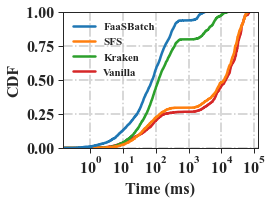

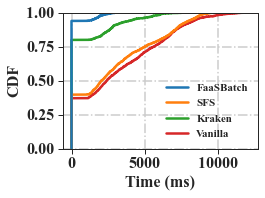

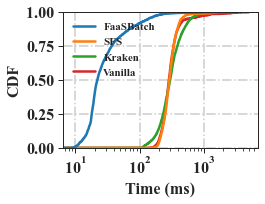

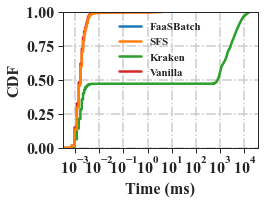

In [13]:
import matplotlib.ticker as ticker


def plot_cdf(data: pd.DataFrame, x: str, hue: str, hue_order: list, light_weight=2.5, x_lable: str = "Execute time (s)"):
    fig, ax = plt.subplots(figsize=(3.5, 2.5))

    sns.ecdfplot(data, x=x, hue=hue, lw=light_weight, hue_order=hue_order)
    sns.move_legend(ax, "best", title=None,
                    frameon=False, fontsize=fontsize-5)
    ax.set_ylabel("CDF", weight='bold')
    ax.set_xlabel(x_lable, weight='bold')
    if 'cold_start' not in x:
        ax.set_xscale("log")
        ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
    # ax.set_title(x)
    return fig


metric_map = {
    'schedule_time(ms)': "scheduleTime",
    'cold_start(ms)': "coldstartTime",
    'exec_time(ms)': "execTime",
    'queue_time(ms)': "queueTime"
}
aux = data[['function', 'schedule_time(ms)', 'cold_start(ms)',
            'queue_time(ms)', 'exec_time(ms)', 'dispatch_interval', 'strategy']]
strategies = aux['strategy'].unique()
for metric, fig_name in metric_map.items():
    fig = plot_cdf(data=aux, x=metric, hue='strategy',
                   hue_order=strategies, x_lable="Time (ms)")
    fig.savefig(f"{PLOT_DIR}/{fig_name}CDFIO.pdf",
                dpi=800, bbox_inches='tight', format='pdf')


#####AWS S3 客户端占用内存评估######
FaaSBatch 创建AWS S3客户端平均消耗的内存为：0.8731164550781251 MB
SFS 创建AWS S3客户端平均消耗的内存为：14.91572509765625 MB
Kraken 创建AWS S3客户端平均消耗的内存为：14.881689453124999 MB
Vanilla 创建AWS S3客户端平均消耗的内存为：14.908896484375001 MB


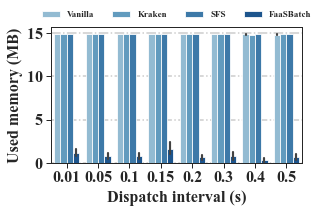

In [11]:
fig, ax1 = plt.subplots(figsize=FIGSIZE)
sns.barplot(x="dispatch_interval", y="used_memory(MB)", hue="strategy", hue_order=legends,
            data=data, palette=mypal, order=sorted(data['dispatch_interval'].unique()))
sns.move_legend(ax1, "lower center", bbox_to_anchor=(.5, 1),
                ncol=4, title=None, frameon=False, fontsize=fontsize-7)
ax1.set_ylabel("Used memory (MB)", weight='bold')
ax1.set_xlabel("Dispatch interval (s)", weight='bold')
fig.savefig(f"{PLOT_DIR}/usedMemoryEachClientAcrossDispatchIntervalsIO.pdf",
            dpi=800, bbox_inches='tight', format='pdf')


print("#####AWS S3 客户端占用内存评估######")

strategies = data['strategy'].unique()
mem_usage_mean_across_interval = {
    strategy: [] for strategy in strategies
}
# 统计数据
for interval, df in data.groupby("dispatch_interval"):
    aux_group = df.groupby("strategy")
    mem_usage_mean = aux_group['used_memory(MB)'].mean()
    for strategy in strategies:
        mem_usage_mean_across_interval[strategy].append(
            mem_usage_mean[strategy])
for strategy, mem_usage_means in mem_usage_mean_across_interval.items():
    print(f"{strategy} 创建AWS S3客户端平均消耗的内存为：{sum(mem_usage_means)/ len(mem_usage_means)} MB")
